# Generate Gaussian Samples

## Positive Samples

We are going to demostrate the RBF network for 3 dimensional Guassian distribution.

In [31]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.set_option("display.max_rows",15)
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
class hp:
    n = 1000
    f = 2

train_mean = np.full(shape=(hp.f), fill_value = 0)
train_var = [[1,0.6],[0.2,3]]

test_mean_1 = np.full(shape=(hp.f), fill_value = 0.5)
test_var_1 = [[1,1.6],[1.6,2]]
test_mean_2 = np.full(shape=(hp.f), fill_value = 10)
test_var_2 = [[1,0.6],[2.2,3]]
test_mean_3 = np.full(shape=(hp.f), fill_value = 20)
test_var_3 = [[1,0.6],[0.2,3]]



class Dataset:
    train_positive = pd.DataFrame(
        np.random.multivariate_normal(mean=train_mean, cov=train_var, size = hp.n))
    
    test_negative_1 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_1, cov=test_var_1, size = hp.n))
    
    test_negative_2 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_2, cov=test_var_2, size = hp.n))
    
    test_negative_3 = pd.DataFrame(
        np.random.multivariate_normal(mean=test_mean_3, cov=test_var_3, size = hp.n))
    

/home/kvpcloud/miniconda3/envs/p3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: covariance is not positive-semidefinite.
/home/kvpcloud/miniconda3/envs/p3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: covariance is not positive-semidefinite.
/home/kvpcloud/miniconda3/envs/p3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: covariance is not positive-semidefinite.
/home/kvpcloud/miniconda3/envs/p3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: covariance is not positive-semidefinite.


## Negative Samples

In [39]:
Dataset.train_positive

,0,1
0,-0.725834,-2.363418
1,0.322537,-0.936481
2,-0.278084,0.873825
3,0.361514,0.716057
4,-1.248279,-0.436798
5,-0.522175,-0.104134
6,-0.120882,0.647332
...,...,...
993,-0.385581,-0.063112
994,0.916363,1.031185


Training Data (Normal)

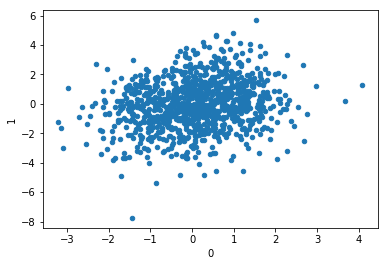

In [60]:
Dataset.train_positive.plot.scatter(x=0, y=1)

Testing Data 1 (Anamoly)

Similar Mean Different Variation

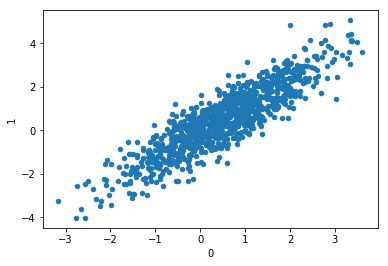

In [59]:
Dataset.test_negative_1.plot.scatter(x=0, y=1)

Testing Data 2 (Anamoly)

Different Mean Different Variation

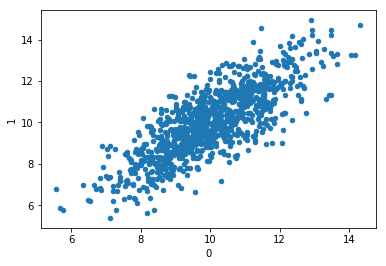

In [58]:
Dataset.test_negative_2.plot.scatter(x=0, y=1)

Testing Data 3 (Anamoly)

Different Mean similar Variation 

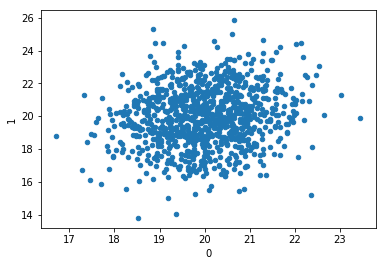

In [57]:
Dataset.test_negative_3.plot.scatter(x=0, y=1)

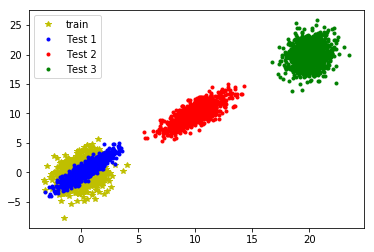

In [94]:
plt.plot(Dataset.train_positive[0], Dataset.train_positive[1], 'y*', label='train')

plt.plot(Dataset.test_negative_1[0], Dataset.test_negative_1[1], 'b.', label='Test 1')
plt.plot(Dataset.test_negative_2[0], Dataset.test_negative_2[1], 'r.', label='Test 2')
plt.plot(Dataset.test_negative_3[0], Dataset.test_negative_3[1], 'g.', label='Test 3')
plt.legend()

In [97]:


class network:
    
    params = {}
    
    def __init__(self):
        self.X = tf.placeholder(tf.float32, [hp.n, hp.f])
        
    def get_cost(self, U, Q, Q_, Z):
        
        inverse_regularizer = tf.pow((tf.matmul(Q, Q_) - tf.eye(hp.f)), 2)
        cost = -(U + tf.log(Z) + tf.reduce_sum(inverse_regularizer))
        
        self.params.update({'U_':tf.reduce_mean(U), 'logZ':tf.log(Z), 'ir': tf.reduce_sum(inverse_regularizer)})
        return tf.reduce_mean(cost)
    
    def get_optimizer(self):
        
        n = hp.n
        f = hp.f
        
        X = self.X
        
        P = tf.Variable(tf.truncated_normal([f]))
        Q = tf.Variable(tf.truncated_normal([f,f]))
        Q_ = tf.Variable(tf.truncated_normal([f,f]))

        M = P - tf.matmul(X, Q)
        print('M', M.get_shape())
        
        R = tf.matmul(M, Q_)
        print('R', R.get_shape())
        
        V = tf.matmul(R, tf.transpose(M))
        print('V', V.get_shape())
        
        U = tf.reduce_sum(V, axis = 1, keepdims = True)
        print('U', U.get_shape())
        
        Q_det = tf.abs(tf.matrix_determinant(Q)) # To avoid get square root of -negative number.
        print('Q_det', Q_det.get_shape())
        
        Z = tf.pow(tf.multiply(tf.pow(6.28,f), Q_det), 1/2)
        print('Z', Z.get_shape())
        
        Y_ = tf.divide(tf.exp(-U/2), Z)
        print("Y_", Y_.get_shape())
        
        loss = self.get_cost(U, Q, Q_, Z) # 1- Y_[0]
        train = tf.train.AdamOptimizer(0.001).minimize(loss)
        
        self.params.update({'U': U, 'M':M, 'R':R, 'Z':Z, 'Q_':Q_, 'Q_det':Q_det})
        
        return train, loss, Y_, self.params


In [98]:
epochs = 1000
net = network()
loss_arr = []
output_tensors = net.get_optimizer()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        X = np.reshape(Dataset.train_positive.values[0:hp.n], (hp.n, -1))
        train, loss, Dataset.Y_, params = sess.run(output_tensors, feed_dict={net.X:X})
        print("epoch", epoch, "loss", loss, 'Z', params['Z'], 'U_', params['U_'], 'LogZ',params['logZ'], 'IR', params['ir'])
        loss_arr.append(loss)
        if(np.abs(loss) < 1):
            break
        #print(params)

M (1000, 2)
R (1000, 2)
V (1000, 1000)
U (1000, 1)
Q_det ()
Z ()
Y_ (1000, 1)
epoch 0 loss 287.57507 Z 1.2533957 U_ -291.10376 LogZ 0.22585641 IR 3.3028483
epoch 1 loss 284.95132 Z 1.2533876 U_ -288.47488 LogZ 0.22584994 IR 3.297701
epoch 2 loss 282.34106 Z 1.2533786 U_ -285.85956 LogZ 0.2258428 IR 3.2925813
epoch 3 loss 279.7446 Z 1.2533687 U_ -283.25793 LogZ 0.22583492 IR 3.2874908
epoch 4 loss 277.162 Z 1.2533573 U_ -280.67017 LogZ 0.22582579 IR 3.28243
epoch 5 loss 274.59323 Z 1.2533439 U_ -278.09644 LogZ 0.22581513 IR 3.2773993
epoch 6 loss 272.03876 Z 1.2533281 U_ -275.53702 LogZ 0.22580248 IR 3.2723992
epoch 7 loss 269.49872 Z 1.2533096 U_ -272.992 LogZ 0.22578774 IR 3.2674303
epoch 8 loss 266.97327 Z 1.2532876 U_ -270.46155 LogZ 0.22577015 IR 3.2624934
epoch 9 loss 264.46252 Z 1.253262 U_ -267.9458 LogZ 0.22574979 IR 3.2575889
epoch 10 loss 261.96655 Z 1.2532322 U_ -265.44507 LogZ 0.22572601 IR 3.252717
epoch 11 loss 259.48566 Z 1.2531977 U_ -262.95923 LogZ 0.22569843 IR 3.2478

In [99]:
pd.DataFrame(Dataset.Y_)

,0
0,inf
1,1.940691e+28
2,2.153140e+30
3,2.514177e+31
4,0.000000e+00
5,inf
6,0.000000e+00
...,...
993,inf
994,inf


In [101]:
pd.DataFrame(params['U'])

,0
0,-314.558289
1,-130.623138
2,-140.041245
3,-144.956451
4,377.589722
5,-340.360779
6,532.609497
...,...
993,-202.452362
994,-413.440247
